<a href="https://colab.research.google.com/github/mrunaliyadav003/AI-ML/blob/main/drone_audio_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 11 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,027 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (71.7 MB/s)
(Reading database ... 123069 files and directories currently installed.)
Removing libcudnn8-dev (8.9.0.131-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.9.0.131-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 123036 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 100
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/paras/drone-audio-detection-develop/data'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      '/content/drive/MyDrive/paras/drone-audio-detection-develop/data',
      origin="/content/drive/MyDrive/paras/drone-audio-detection-develop",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['outside_sound' 'test_sound' 'indoor_sound' 'drone_sound' '0801']


In [ ]:
ALLOWED_FORMATS = ('.wav', '.mp3', '.aac')


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.5,
    seed=100,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 4 files belonging to 5 classes.
Using 2 files for training.
Using 2 files for validation.

label names: ['0801' 'drone_sound' 'indoor_sound' 'outside_sound' 'test_sound']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [68]:
test_ds = val_ds.shard(num_shards=2, index=1)
val_ds = val_ds.shard(num_shards=2, index=1)

In [69]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(2, 16000)
(2,)


In [70]:
label_names[[1,1,3,0]]

array(['drone_sound', 'drone_sound', 'outside_sound', '0801'],
      dtype='<U13')

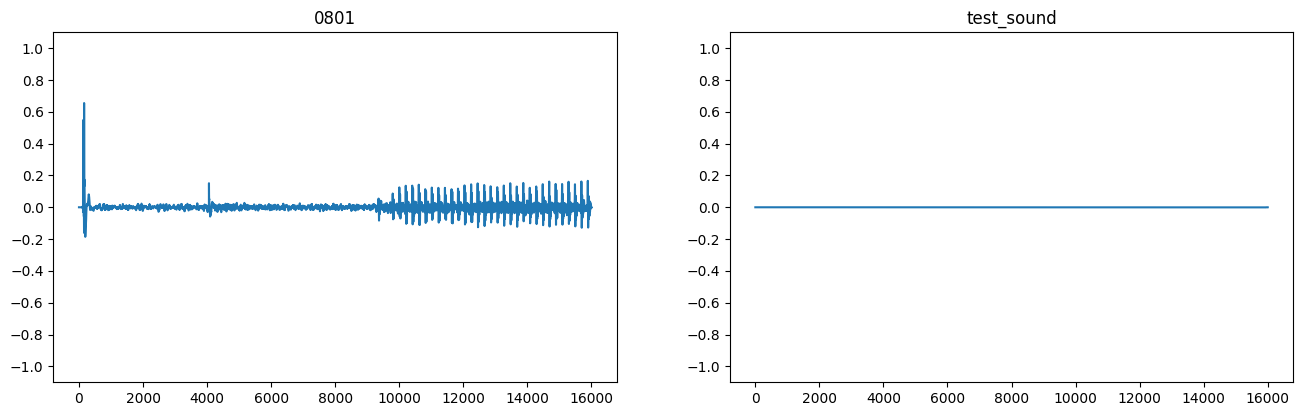

In [71]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols

if len(example_audio) <= n:
    n = len(example_audio)

for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])


In [72]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [91]:
if len(example_labels) >= 2:
  for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))
else:
  print('example_labels does not have at least 3 elements.')


Label: 0801
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: test_sound
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


InvalidArgumentError: ignored

In [92]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

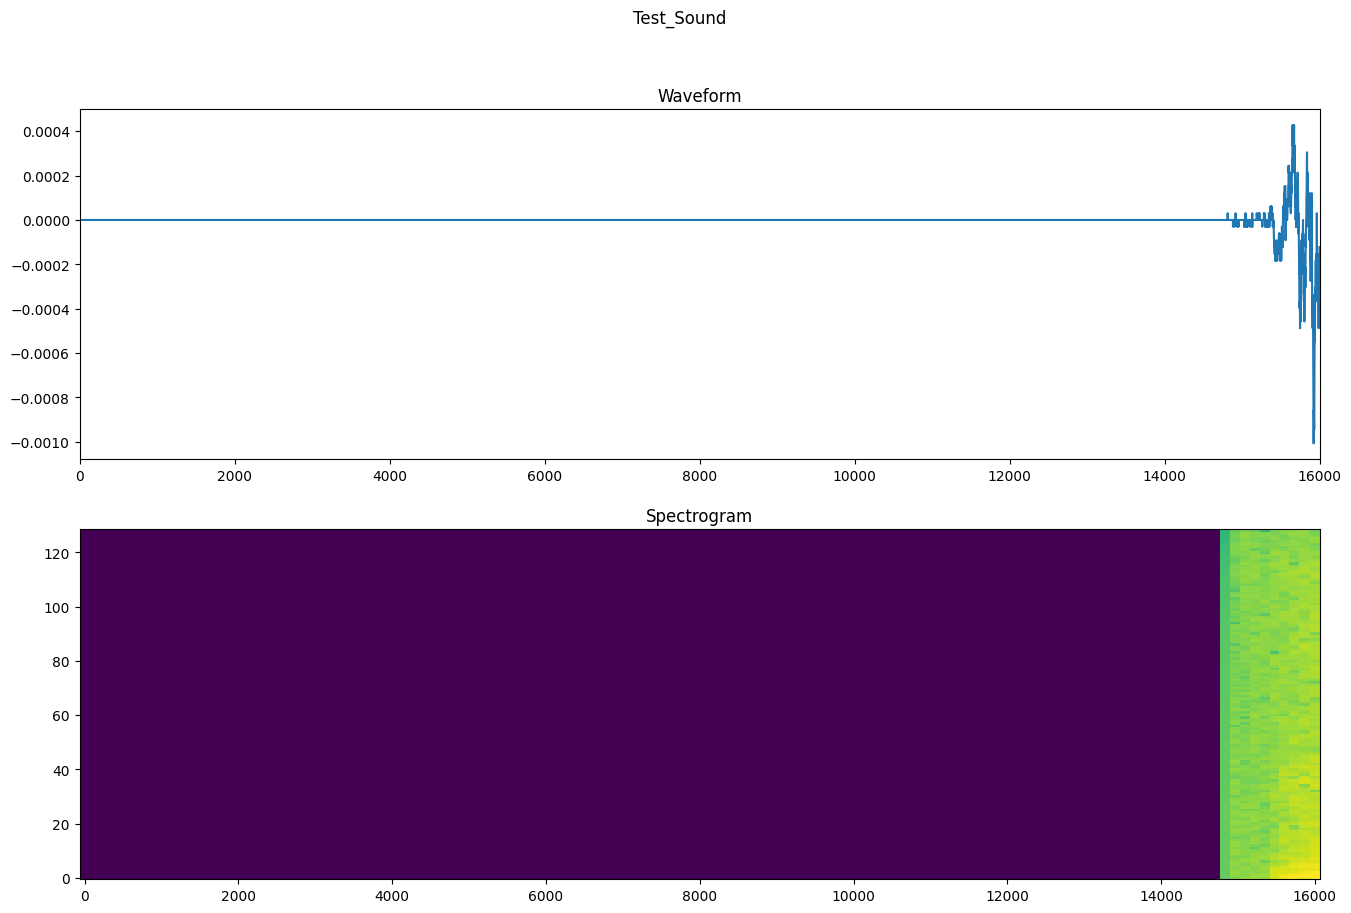

In [93]:
fig, axes = plt.subplots(2, figsize=(16, 10))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

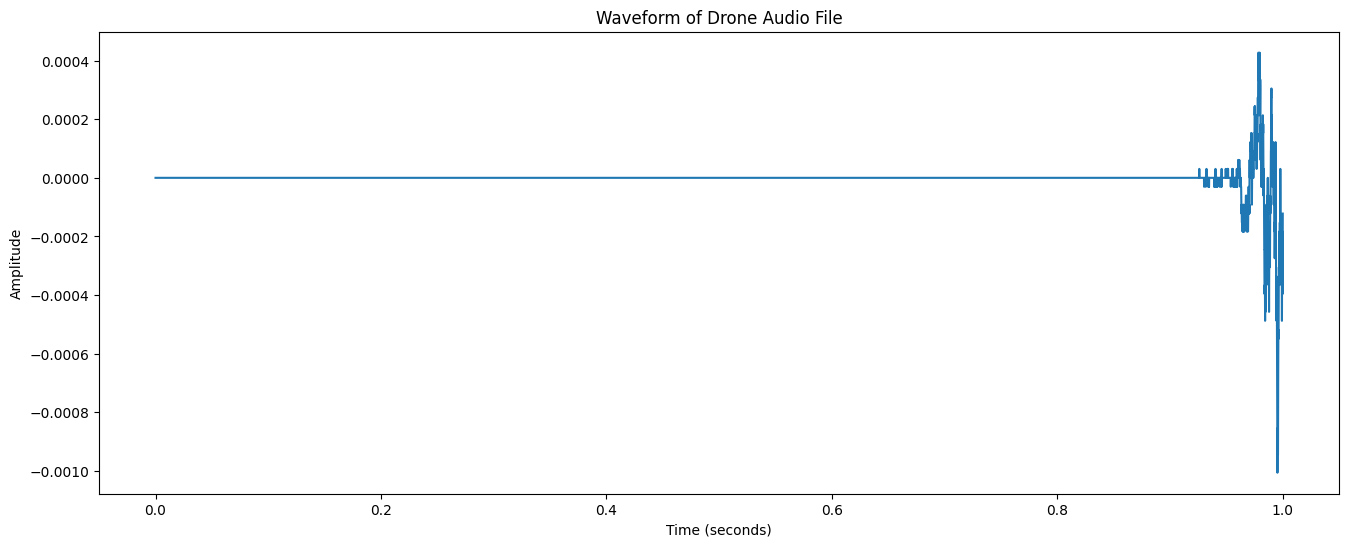

In [94]:
import matplotlib.pyplot as plt

# Assuming that waveform contains the audio data for a single drone file at 16000 Hz sample rate
plt.figure(figsize=(16, 6))
timescale = np.arange(waveform.shape[0]) / 16000 # convert time to seconds
plt.plot(timescale, waveform.numpy())
plt.title('Waveform of Drone Audio File')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


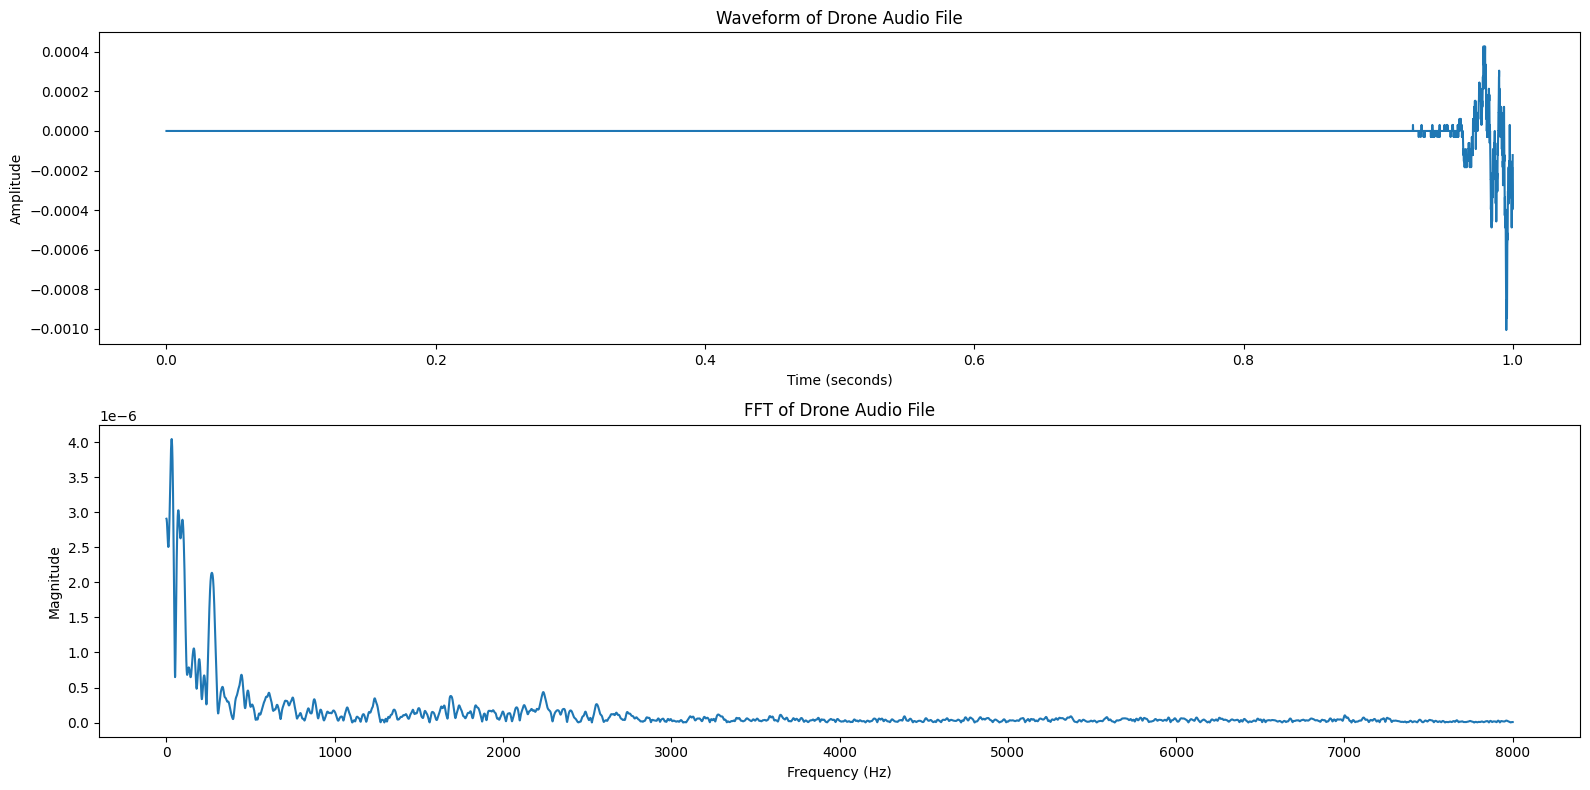

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming that waveform contains the audio data for a single drone file at 16000 Hz sample rate
plt.figure(figsize=(16, 8))

# Plot the waveform
timescale = np.arange(waveform.shape[0]) / 16000 # convert time to seconds
plt.subplot(2, 1, 1)
plt.plot(timescale, waveform.numpy())
plt.title('Waveform of Drone Audio File')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Compute and plot the FFT
n_samples = waveform.shape[0]
dft = np.abs(np.fft.rfft(waveform.numpy())) / n_samples
freqs = np.fft.rfftfreq(n_samples, d=1/16000)
plt.subplot(2, 1, 2)
plt.plot(freqs, dft)
plt.title('FFT of Drone Audio File')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [96]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [97]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [98]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [106]:
rows = 2
cols = 2
n = rows * cols

if len(example_spectrograms) >= n:
    fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

    for i in range(n):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        plot_spectrogram(example_spectrograms[i].numpy(), ax)
        ax.set_title(label_names[example_spect_labels[i].numpy()])

    plt.show()
else:
    print(f'Cannot plot: example_spectrograms only has {len(example_spectrograms)} elements.')


Cannot plot: example_spectrograms only has 2 elements.


In [107]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [108]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [109]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [113]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

1/1 [==============================] - 0s 143ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 1.0000

1/1 [==============================] - 0s 130ms/step - loss: 0.0318 - accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 6.8707e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 129ms/step - loss: 6.8707e-04 - accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

1/1 [==============================] - 0s 126ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 7.2534e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 134ms/step - loss: 7.2534e-05 - accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 4.3569e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 134ms/step - loss: 4.3569e-05 - accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 1.1325e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 164ms/step - loss: 1.1325e-06 - accuracy: 1.0000
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 1.9073e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 161ms/step - loss: 1.9073e-06 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 7.5101e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 155ms/step - loss: 7.5101e-06 - accuracy: 1.0000
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.5000

1/1 [==============================] - 0s 159ms/step - loss: 0.7908 - accuracy: 0.5000
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 7.2409e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 162ms/step - loss: 7.2409e-04 - accuracy: 1.0000
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 3.3378e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 182ms/step - loss: 3.3378e-06 - accuracy: 1.0000
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 1.1921e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 161ms/step - loss: 1.1921e-06 - accuracy: 1.0000
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 5.9605e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 166ms/step - loss: 5.9605e-08 - accuracy: 1.0000
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 2.5689e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 236ms/step - loss: 2.5689e-05 - accuracy: 1.0000
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 1.7881e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 239ms/step - loss: 1.7881e-07 - accuracy: 1.0000
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: 6.0200e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 222ms/step - loss: 6.0200e-04 - accuracy: 1.0000
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: 6.9094e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 234ms/step - loss: 6.9094e-04 - accuracy: 1.0000
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: 1.4484e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 256ms/step - loss: 1.4484e-05 - accuracy: 1.0000
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: 2.1636e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 250ms/step - loss: 2.1636e-05 - accuracy: 1.0000
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

1/1 [==============================] - 0s 237ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: 1.1514e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 242ms/step - loss: 1.1514e-04 - accuracy: 1.0000
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

1/1 [==============================] - 0s 229ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

1/1 [==============================] - 0s 253ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

1/1 [==============================] - 0s 256ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: 1.7914e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 231ms/step - loss: 1.7914e-04 - accuracy: 1.0000
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 1.0000

1/1 [==============================] - 0s 229ms/step - loss: 0.0182 - accuracy: 1.0000
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

1/1 [==============================] - 0s 270ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

1/1 [==============================] - 0s 229ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: 5.4223e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 228ms/step - loss: 5.4223e-04 - accuracy: 1.0000
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 1.0000

1/1 [==============================] - 0s 151ms/step - loss: 0.0395 - accuracy: 1.0000
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 1.0000

1/1 [==============================] - 0s 165ms/step - loss: 0.0331 - accuracy: 1.0000
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 5.1174e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 163ms/step - loss: 5.1174e-04 - accuracy: 1.0000
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 1.0000

1/1 [==============================] - 0s 148ms/step - loss: 0.0423 - accuracy: 1.0000
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: 3.5046e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 158ms/step - loss: 3.5046e-05 - accuracy: 1.0000
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: 8.9988e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 171ms/step - loss: 8.9988e-04 - accuracy: 1.0000
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: 8.9280e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 156ms/step - loss: 8.9280e-05 - accuracy: 1.0000
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: 7.1439e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 159ms/step - loss: 7.1439e-04 - accuracy: 1.0000
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: 1.3649e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 160ms/step - loss: 1.3649e-05 - accuracy: 1.0000
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

1/1 [==============================] - 0s 159ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: 1.5912e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 166ms/step - loss: 1.5912e-04 - accuracy: 1.0000
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 9.9001e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 157ms/step - loss: 9.9001e-04 - accuracy: 1.0000
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 5.6264e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 162ms/step - loss: 5.6264e-05 - accuracy: 1.0000
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 3.3784e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 160ms/step - loss: 3.3784e-04 - accuracy: 1.0000
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 8.3916e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 157ms/step - loss: 8.3916e-05 - accuracy: 1.0000
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 1.0000

1/1 [==============================] - 0s 164ms/step - loss: 0.1447 - accuracy: 1.0000
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: 8.0466e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 166ms/step - loss: 8.0466e-06 - accuracy: 1.0000
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: 1.8775e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 174ms/step - loss: 1.8775e-05 - accuracy: 1.0000
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: 6.1111e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 170ms/step - loss: 6.1111e-04 - accuracy: 1.0000
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: 2.4437e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 156ms/step - loss: 2.4437e-05 - accuracy: 1.0000


In [117]:
print(metrics.keys())


dict_keys(['loss', 'accuracy'])


Text(0, 0.5, 'Accuracy [%]')

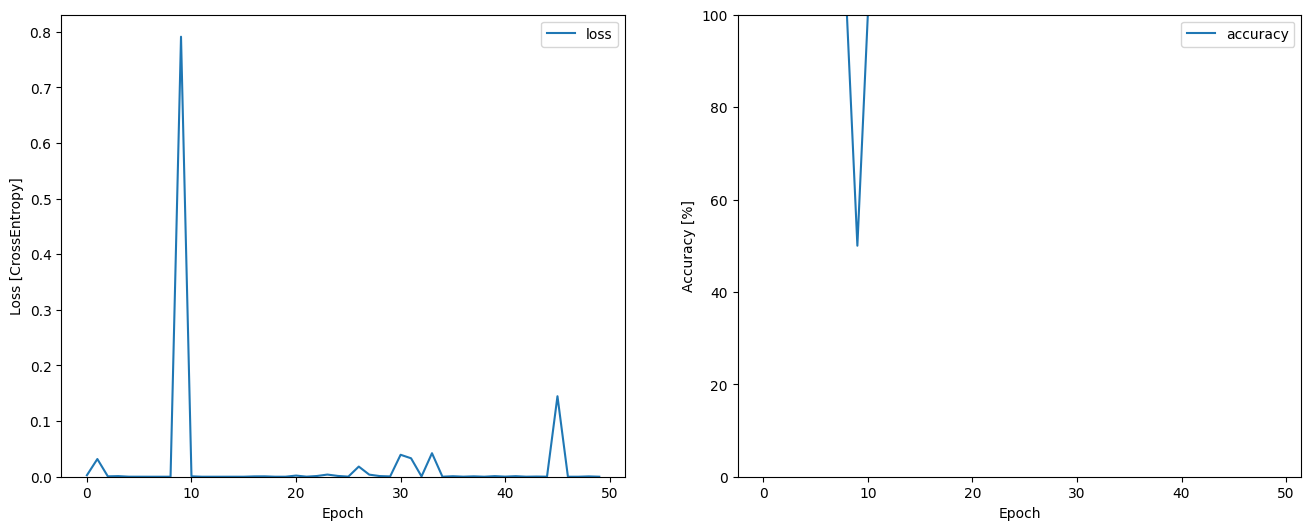

In [123]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'])
if 'val_loss' in metrics:
    plt.plot(history.epoch, metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
else:
    plt.legend(['loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']))
if 'val_accuracy' in metrics:
    plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
else:
    plt.legend(['accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [125]:
import os
import tensorflow as tf

# Define audio processing parameters
sample_rate = 16000
num_mels = 128
frame_length = 2048
frame_step = 512

# Define output directory
output_dir = 'path/to/output/directory/'

# Iterate over all audio files in directory
audio_dir = '/content/drive/MyDrive/paras/drone-audio-detection-develop/data'
for filename in os.listdir(audio_dir):
    if filename.endswith('.wav'):
        # Load audio file
        audio_file = os.path.join(audio_dir, filename)
        audio_binary = tf.io.read_file(audio_file)
        audio, _ = tf.audio.decode_wav(audio_binary)

        # Convert to mono and resample to desired rate
        audio_mono = tf.squeeze(tf.reduce_mean(audio, axis=-1), axis=-1)
        audio_resampled = tf.signal.resample(audio_mono, int(sample_rate * audio_mono.shape[0] / audio.sample_rate))

        # Compute spectrogram
        stft = tf.signal.stft(audio_resampled, frame_length=frame_length, frame_step=frame_step, pad_end=True)
        spectrogram = tf.abs(stft)

        # Convert to mel-scale
        mel_filterbank = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mels, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=sample_rate, lower_edge_hertz=20.0, upper_edge_hertz=sample_rate/2)
        mel_spectrogram = tf.matmul(tf.square(spectrogram), mel_filterbank)

        # Apply logarithmic compression
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

        # Normalize the spectrogram
        mean = tf.reduce_mean(log_mel_spectrogram)
        stddev = tf.math.reduce_std(log_mel_spectrogram)
        normalized_spectrogram = (log_mel_spectrogram - mean) / stddev

        # Save the normalized spectrogram to disk
        output_filename = os.path.join(output_dir, filename.replace('.wav', '.npy'))
        tf.io.write_file(output_filename, tf.io.serialize_tensor(normalized_spectrogram))


In [152]:
import numpy as np

# Check for NaN or infinite values in the input data
def check_data(data):
    if np.isnan(data).any() or np.isinf(data).any():
        print("Input data contains NaN or infinite values!")
        return False
    else:
        return True

# Scale the input data to improve stability
def scale_data(data):
    max_val = np.max(data)
    scaled_data = data / max_val
    return scaled_data

# Placeholder function to load input data
def audio_dir():
    # Replace this with the actual code or function that loads your input data
    X_test = np.random.rand(100, 124, 129, 1)
    return X_test

# Load the input data
X_test = audio_dir()

# Check for NaN or infinite values
if not check_data(X_test):
    exit()

# Scale the input data
X_test = scale_data(X_test)

# Placeholder value for y_test
y_test = None

# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)


4/4 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [155]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(124, 129, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with appropriate loss and optimizer functions
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)

# Print a summary of the model architecture and parameters
model.summary()

# Load the test data
test_spectrogram_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(64)

# Generate predictions for the test data
y_pred = model.predict(test_spectrogram_ds)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 122, 127, 32)      320       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 61, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 29, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 55680)             0         
                                                                 
 dense_40 (Dense)            (None, 64)              

In [156]:
y_pred = tf.argmax(y_pred, axis=1)

In [157]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

TypeError: ignored

In [163]:
# Load the test data and labels separately (if available)
if y_test is None:
    test_spectrogram_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(64)
else:
    test_spectrogram_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Generate predictions for the test data
y_pred = model.predict(test_spectrogram_ds)

# If test labels are not available, create a dummy label dataset with all zeros
if y_test is None:
    num_samples = X_test.shape[0]
    y_dummy = np.zeros((num_samples,))
    test_label_ds = tf.data.Dataset.from_tensor_slices(y_dummy).batch(64)
    y_true = y_dummy
else:
    # Concatenate the true labels from the label dataset
    test_label_ds = tf.data.Dataset.from_tensor_slices(y_test).batch(64)
    y_true = tf.concat(list(test_label_ds), axis=0)

# Convert the predicted probabilities to binary labels using a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_binary))


2/2 [==============================] - 1s 355ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.85       100
   macro avg       0.50      0.42      0.46       100
weighted avg       1.00      0.85      0.92       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


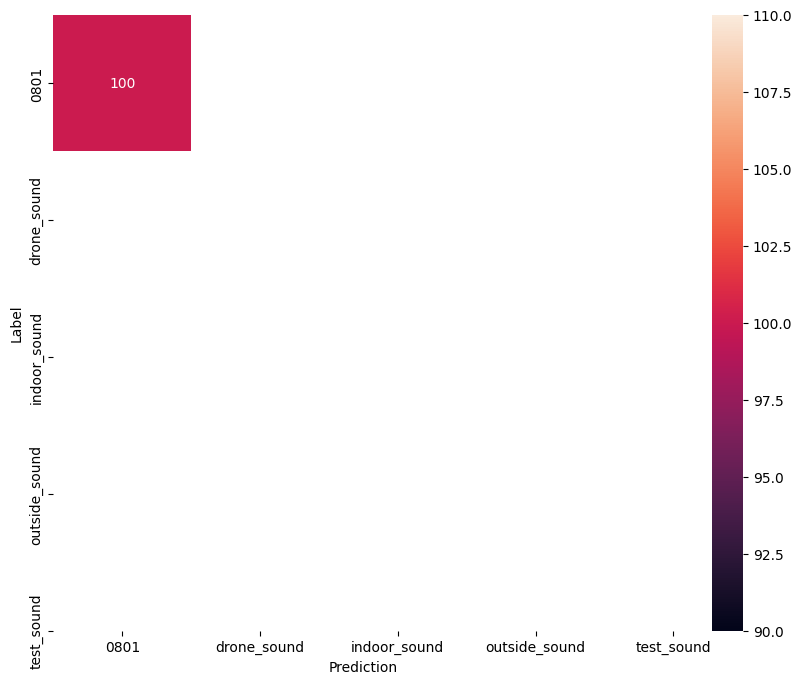

In [164]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [174]:
import os
import subprocess

# Set the input and output directories
input_dir = '/content/drive/MyDrive/paras/drone-audio-detection-develop/data'
output_dir = '/content/drive/MyDrive/paras/drone-audio-detection-develop/data/subprocess'

# Loop over all files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.mp3'):
        # Construct the input and output file paths
        input_file = os.path.join(input_dir, filename)
        output_file = os.path.join(output_dir, os.path.splitext(filename)[0] + '.wav')

        # Convert the MP3 file to WAV using ffmpeg
        subprocess.call(['ffmpeg', '-i', input_file, output_file])

        # Read the WAV file and decode it
        wav_data = tf.io.read_file(output_file)
        waveform, sample_rate = tf.audio.decode_wav(wav_data)

        # Convert the waveform to a mono-channel signal
        waveform = tf.squeeze(waveform, axis=-1)

        # Resample the waveform if necessary
        if sample_rate != 16000:
            waveform = tf.signal.resample(waveform, resampling_rate=16000)

        # Compute the spectrogram
        spectrogram = get_spectrogram(waveform)
        spectrogram = spectrogram[tf.newaxis,...]

        # Make the prediction using the trained model
        prediction = model(spectrogram)

        # Visualize the prediction as a bar chart
        x_labels = ['drone_sound', 'drone_sound', 'outside_sound', '0801']
        plt.bar(x_labels, tf.nn.softmax(prediction[0]))
        plt.title(filename)
        plt.show()

        # Play the audio using IPython.display.Audio
        display.display(display.Audio(waveform, rate=16000))


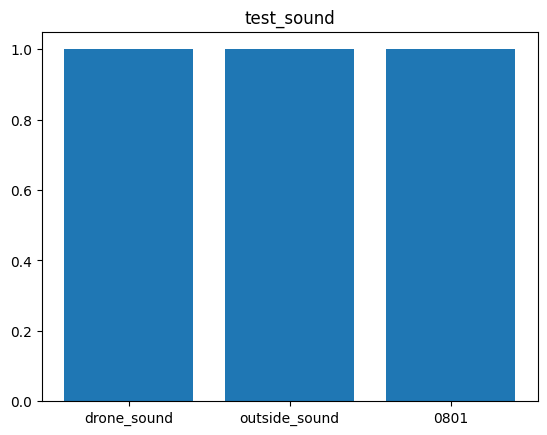

In [181]:
x = data_dir/'/content/drive/MyDrive/paras/drone-audio-detection-develop/data/test_sound/sound1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['drone_sound', 'drone_sound', 'outside_sound', '0801']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('test_sound')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [182]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [183]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'/content/drive/MyDrive/paras/drone-audio-detection-develop/data/test_sound/sound1.wav')))

{'predictions': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5000021]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'0801'], dtype=object)>}

In [184]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'0801'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5000021]], dtype=float32)>}

In [186]:
output = imported(waveform[tf.newaxis, :])
print(output.keys())


dict_keys(['class_ids', 'class_names', 'predictions'])


In [187]:
output = imported(waveform[tf.newaxis, :])
score_key = "predictions"  # Replace with the actual key name
score = output[score_key][0]

if score > 0.5:
    print("Drone detected")
else:
    print("No drone detected")


Drone detected
